In [6]:
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder

# Fungsi untuk memuat gambar dan label
def load_images_from_directory(directory):
    images = []
    labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                if file.lower().endswith('.ppm'):
                    image_path = os.path.join(label_dir, file)
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (128, 128))  # Resize gambar menjadi 128x128
                    images.append(image)
                    labels.append(label)

    return np.array(images), np.array(labels)

# Path ke data pelatihan dan validasi
train_dir = 'data/train_crops'
val_dir = 'data/val_crops'

# Memuat dan memproses gambar
X_train, y_train = load_images_from_directory(train_dir)
X_val, y_val = load_images_from_directory(val_dir)

# Normalisasi gambar
X_train = X_train / 255.0
X_val = X_val / 255.0

# Gabungkan label dari X_train dan X_val untuk memastikan bahwa semua label terencode dengan benar
all_labels = np.concatenate([y_train, y_val])

# Encode label menjadi numerik
encoder = LabelEncoder()
encoder.fit(all_labels)  # Fit pada semua label

# Menampilkan jumlah kelas dan beberapa label yang terencode
print(f"Total kelas: {len(encoder.classes_)}")
print(f"Beberapa label yang terencode: {encoder.classes_[:10]}")

# Encode data latih dan validasi
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

# Periksa apakah ada label yang melebihi jumlah kelas
print("Label train max:", np.max(y_train))
print("Label val max:", np.max(y_val))

# Pastikan tidak ada label yang lebih besar dari jumlah kelas
assert np.max(y_train) < len(encoder.classes_), "Ada label yang lebih besar dari jumlah kelas"
assert np.max(y_val) < len(encoder.classes_), "Ada label yang lebih besar dari jumlah kelas"

# Split data latih untuk validasi (jika diperlukan)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Total kelas: 190
Beberapa label yang terencode: ['S001' 'S006' 'S008' 'S013' 'S015' 'S022' 'S023' 'S027' 'S029' 'S030']
Label train max: 189
Label val max: 189


In [40]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Definisikan jumlah kelas
num_classes = 190  # Sesuaikan dengan jumlah kelas yang kamu miliki

# Inisialisasi model Sequential
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),  # Input shape sesuai dengan data
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout untuk regularisasi
    layers.Dense(num_classes, activation='softmax')  # Output layer sesuai jumlah kelas
])

# Menampilkan summary model
model.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 190)            │        24,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329,150 (12.70 MB)

 Trainable params: 3,329,150 (12.70 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np

# Definisikan jumlah kelas
num_classes = 190  # Sesuaikan dengan jumlah kelas yang kamu miliki

# Inisialisasi model Sequential
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),  # Input shape harus disesuaikan dengan data
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout untuk regularisasi
    Dense(num_classes, activation='softmax')  # Output layer sesuai jumlah kelas
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.7  # Turunkan learning rate sebesar 30% setiap 10 epoch
    return lr

lr_schedule = LearningRateScheduler(lr_scheduler)

# Pastikan ukuran input data sesuai
X_train = tf.image.resize(X_train, (128, 128))  # Resize jika perlu
X_val = tf.image.resize(X_val, (128, 128))

# Latih model dengan data pelatihan
history = model.fit(
    X_train, 
    y_train, 
    epochs=100,  # Gunakan lebih banyak epoch
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[lr_schedule]  # Hanya LearningRateScheduler tanpa EarlyStopping
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.0066 - loss: 5.2674 - val_accuracy: 0.0000e+00 - val_loss: 5.2515 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.0039 - loss: 5.2396 - val_accuracy: 0.0112 - val_loss: 5.2506 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.0019 - loss: 5.1961 - val_accuracy: 0.0000e+00 - val_loss: 5.2311 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.0258 - loss: 5.0569 - val_accuracy: 0.0169 - val_loss: 5.0357 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.0747 - loss: 4.6701 - val_accuracy: 0.0899 - val_loss: 4.6363 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.1321 - loss: 4.2059 - val_accuracy: 0.2360 - val_loss: 4.0450 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.2133 - 

In [38]:
# Evaluasi model dengan data validasi
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test accuracy: {test_acc * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8038 - loss: 1.8119
Test accuracy: 83.15%


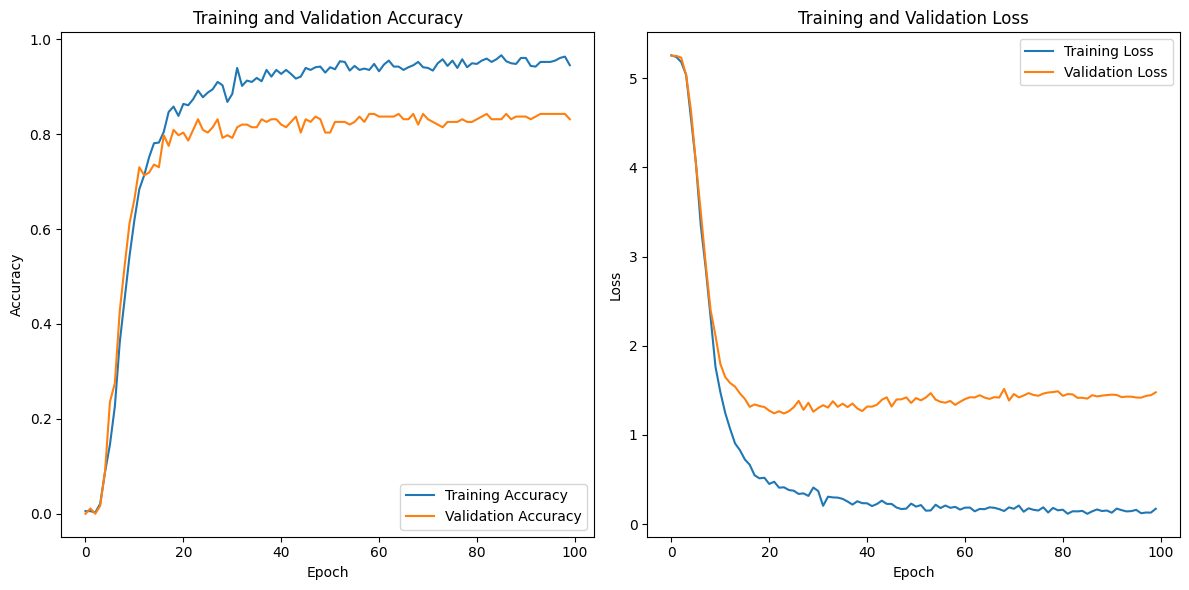

In [39]:
import matplotlib.pyplot as plt

# Mengambil data dari history
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot akurasi pelatihan dan validasi
plt.figure(figsize=(12, 6))

# Subplot untuk Akurasi
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()
